In [2]:
# to run this notebook, ensure that valpy is installed (pip install .) in your virtual environment
from valpy.model import ValidationModel
import rudolfpy as rd
import numpy as np
import matplotlib.pyplot as plt

/opt/homebrew/Caskroom/miniconda/base/envs/scratch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# This block sets up the measurement model, filter, and dynamics

## ground truth initial conditions for targets and observers
groundtruth_targets = np.array([[
        1.1540242813087864,
        0.0,
        -0.1384196144071876,
        4.06530060663289e-15,
        -0.21493019200956867,
        8.48098638414804e-15
    ]])
groundtruth_observers = np.array([[
        0.8027692908754149,
        0.0,
        0.0,
        -1.1309830924549648e-14,
        0.33765564334938736,
        0.0
    ]])

# CR3BP dynamics parameters
mu = 1.215058560962404e-02
LU = 384400
TU = 3.751902619517228e+05
VU = LU / TU

# positional uncertainty (is used to compute initial covariance of target and observer state)
sigma_r0 = 100 / LU
sigma_v0 = 0.001 / VU

# measurement model uncertainty in angle measurement
sigma_phi = np.deg2rad(0.1)
# measurement model time of exposure for sensor measurement
dt_meas = 3600/TU

# estimates for (x0, P0) for observer and targets
estimate_observers = np.array([groundtruth_observers[0] + np.array([sigma_r0]*3 + [sigma_v0]*3) * np.random.normal(0, 1, 6)])
estimate_targets = np.array([groundtruth_targets[0] + np.array([sigma_r0]*3 + [sigma_v0]*3) * np.random.normal(0, 1, 6)])
P0_observers = np.array([np.diag([sigma_r0]*3 + [sigma_v0]*3)**2])
P0_targets = np.array([np.diag([sigma_r0]*3 + [sigma_v0]*3)**2])

# create dynamics model
dynamics = rd.DynamicsCR3BP(mu = mu, LU=LU, TU=TU, method='DOP853', rtol = 1e-12, atol = 1e-12)
# create measurement model
meas_model = rd.MeasurementAngleAngleRate()
# process noise
params_Q = [1e-5,]
# create EKF object
filter = rd.UnscentedKalmanFilter(dynamics, meas_model,
                                 func_process_noise = rd.unbiased_random_process_3dof,
                                 params_Q = params_Q,)
# timestep of simulation
timestep = 0.015

# simulate randome control
u = np.random.randint(low=0, high=2, size=(1, 1, 215))


In [3]:
isinstance(filter, rd.BaseFilter)

True

In [4]:
# create ValidationModel Object
vm = ValidationModel(u=u,
                     groundtruth_observers=groundtruth_observers,
                     groundtruth_targets=groundtruth_targets,
                     estimate_observers=estimate_observers,
                     estimate_targets=estimate_targets,
                     P0_observers=P0_observers,
                     P0_targets=P0_targets,
                     filter=filter,
                     timestep=timestep)

In [5]:
# get measurement parameters for the state of the observer. The measurement is taken by
# an observer on the moon!
observer_idx = 0
t_measurements = np.linspace(0.05, 3.225, 10)
t_eval = np.linspace(0, 3.225, 100)
x_observer = [1.0 - mu, 0, 0, 0, 0, 0]
params_measurements = [[x_observer, sigma_phi, dt_meas]]*t_measurements.size

In [6]:
# get filtered and ground truth state history
observer_history = vm._get_observer_history_filter(observer_idx=observer_idx,
                                params_measurements=params_measurements,
                                t_measurements=t_measurements,
                                t_eval=t_eval)
observer_history_gt = vm._get_observer_history_groundtruth(0, t_eval=t_eval)


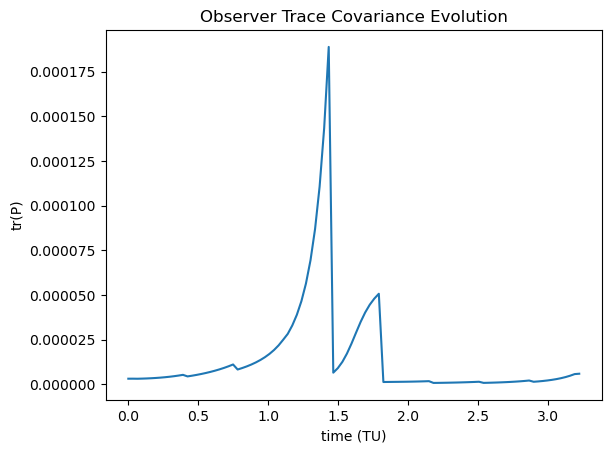

In [7]:
# plot the trace(P) over time
observer_history_trP = np.array([np.trace(item[1]) for item in observer_history])
plt.plot(t_eval, observer_history_trP)
plt.xlabel("time (TU)")
plt.ylabel("tr(P)")
plt.title("Observer Trace Covariance Evolution")
plt.show()

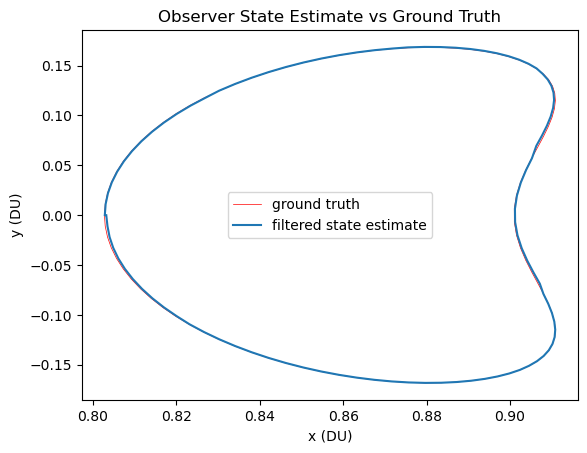

In [8]:
# plot the state estimate against the ground truth
observer_history_r = np.array([item[0][:3] for item in observer_history])
observer_history_rgt = np.array([item[0][:3] for item in observer_history_gt])
plt.plot(observer_history_rgt[:,0], observer_history_rgt[:,1], color="red", linewidth=0.5, label="ground truth")
plt.plot(observer_history_r[:,0], observer_history_r[:,1], label="filtered state estimate")

plt.xlabel("x (DU)")
plt.ylabel("y (DU)")
plt.title("Observer State Estimate vs Ground Truth")
plt.legend()
plt.show()

In [9]:
target_idx = 0
# t_eval = np.linspace(0, 3.225, 100)
t_eval = None
params_measurements = []

In [10]:
# get target filtered state and ground truth history
target_history = vm._get_target_history_filter(target_idx=target_idx,
                                               params_measurements=params_measurements,
                                               t_eval=t_eval)
target_history_gt = vm._get_target_history_groundtruth(target_idx=target_idx,
                                                       t_eval=t_eval)

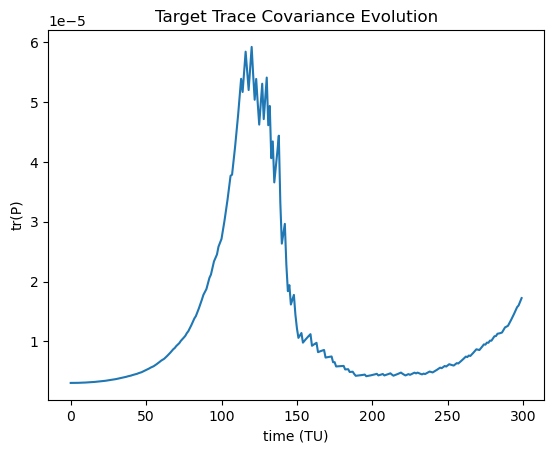

In [11]:
# plot trace(P) of target over time
target_history_trP = np.array([np.trace(item[1]) for item in target_history])
plt.plot(target_history_trP)
plt.xlabel("time (TU)")
plt.ylabel("tr(P)")
plt.title("Target Trace Covariance Evolution")
plt.show()

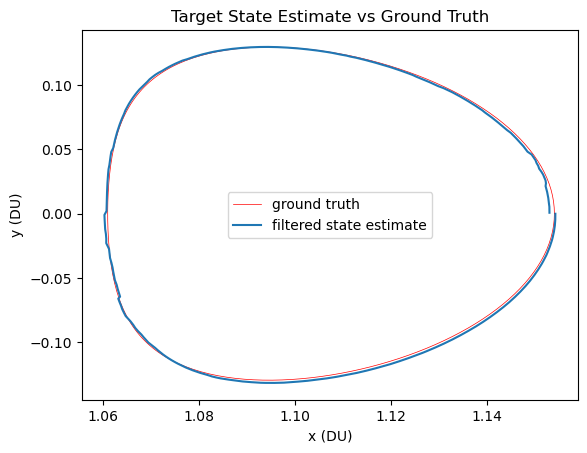

In [12]:
# plot ground truth and filtered state estimate
target_history_r = np.array([item[0][:3] for item in target_history])
target_history_rgt = np.array([item[0][:3] for item in target_history_gt])
plt.plot(target_history_rgt[:,0], target_history_rgt[:,1], color="red", linewidth=0.5, label="ground truth")
plt.plot(target_history_r[:,0], target_history_r[:,1], label="filtered state estimate")
plt.xlabel("x (DU)")
plt.ylabel("y (DU)")
plt.title("Target State Estimate vs Ground Truth")
plt.legend()
plt.show()